# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 4** of the miniproject.

#### Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
#from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Load data
Load previously saved dataframe as `.csv` file:

In [3]:
main_dir = r'/Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/' # EDIT the path !!!!!!!
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: /Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/


Look at what are the different categories in the data.

In [4]:
print(data_df.columns)

Index(['Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter', 'Cell_Depth',
       'Cell_ID', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type',
       'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype',
       'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes', 'Sweep_Counter',
       'Sweep_MembranePotential', 'Sweep_MembranePotential_SamplingRate',
       'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime',
       'Sweep_Type', 'Sweep_WhiskerAngle', 'Sweep_WhiskerAngle_SamplingRate',
       'Sweep_WhiskingTimes'],
      dtype='object')


# Analysis

Set general general parameters that we will use:

In [52]:
sweep_type = 'active touch'

pre_window = 0.05 # time before whisking onset (s)
post_window = 0 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3], 'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP)

Find the free whisking cells and all the unique recorded cells in the data

In [6]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 
all_cells = np.unique(data_df_subset.Cell_ID)
cell_nb = len(all_cells)
print('Number of cells:', cell_nb)

Number of cells: 134


Plot the whisker angle for one particular cell

In [7]:
data_df_subset['Sweep_WhiskerAngle'][1]

array([2.68      , 2.68      , 2.68      , ..., 4.01341959, 4.01482351,
       4.08418533])

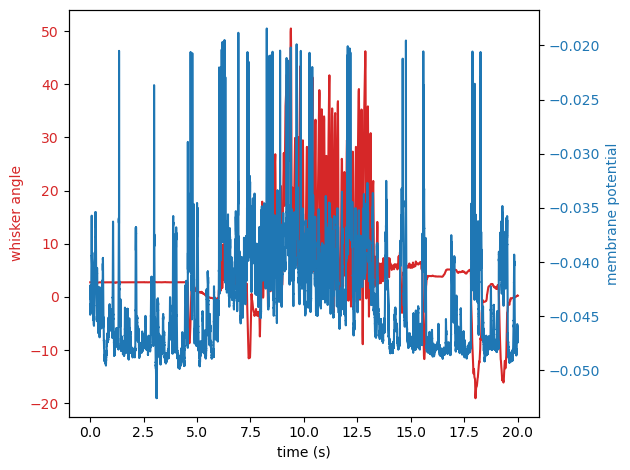

Cell type =  EXC ; Sweep type =  active touch ; length of array =  2000
20.0 20.0
5.668404808190949


In [96]:
one_cell = 0
whisker = data_df_subset['Sweep_WhiskerAngle'][one_cell] # all whisker angles for one particular cell for free whisking
potential = data_df_subset['Sweep_MembranePotential'][one_cell]

n = len(data_df_subset['Sweep_WhiskerAngle'][one_cell])
m = len(data_df_subset['Sweep_MembranePotential'][one_cell])
time = n /data_df_subset['Sweep_WhiskerAngle_SamplingRate'][one_cell]
time2 = m /data_df_subset['Sweep_MembranePotential_SamplingRate'][one_cell]
whiskerTime = [np.arange(1,n+1)/100, whisker]
potentialTime = [np.arange(1,m+1)/20000, potential]


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('whisker angle', color=color)
ax1.plot(whiskerTime[0], whiskerTime[1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('membrane potential', color=color)  # we already handled the x-label with ax1
ax2.plot(potentialTime[0], potentialTime[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Cell type = ', data_df_subset['Cell_Type'][one_cell], '; Sweep type = ', data_df_subset['Sweep_Type'][one_cell], '; length of array = ', n)
print(time, time2)
avg = whisker.mean()
print(avg)


In [43]:
cell = 0

cell_type = data_df_subset.Cell_Type.values[cell]
event_times = data_df_subset['Sweep_ActiveContactTimes'].values[cell]
sr_vm = data_df_subset['Sweep_MembranePotential_SamplingRate'].values[cell] #[0] to get the content of the array
membrane_potential = data_df_subset['Sweep_MembranePotential'].values[cell]
ap_vm_deriv_thresh = data_df_subset['Cell_APThreshold_Slope'].values[cell]
        
# Template: extract whisker angle and sampling rate of whisker video data
wp = data_df_subset['Sweep_WhiskerAngle'].values[cell]
sr_wp = data_df_subset['Sweep_WhiskerAngle_SamplingRate'].values[cell]
wp_time = np.arange(len(wp))/sr_wp
vm_time = np.arange(len(membrane_potential))/sr_vm

good_event_times = []
print(len(event_times))
for i in np.arange(len(event_times)):
    print(i)
    if i == len(event_times)-1:
        good_event_times.append(event_times[i])
    elif event_times[i+1][0] - event_times[i][1] > min_iti:
        good_event_times.append(event_times[i])

print(good_event_times)


8
0
1
2
3
4
5
6
7
[array([6.207, 6.217]), array([10.385, 10.393]), array([11.177, 11.183]), array([12.117, 12.147])]


6.157000000000001 6.227


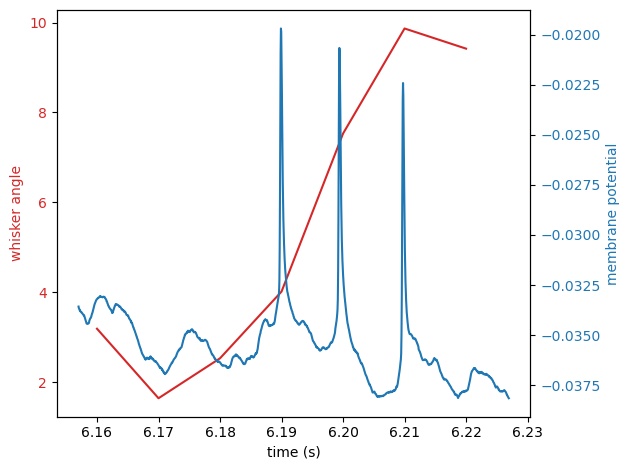

In [48]:
fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('whisker angle', color=color)
pre = good_event_times[0][0]-pre_window
post = good_event_times[0][1]+post_window
print(pre,post)
pre_wp = round(pre*sr_wp)
post_wp = round(post*sr_wp)
pre_vm = round(pre*sr_vm)
post_vm = round(post*sr_vm)
ax1.plot(wp_time[pre_wp:post_wp], wp[pre_wp:post_wp], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('membrane potential', color=color)  # we already handled the x-label with ax1
ax2.plot(vm_time[pre_vm:post_vm], membrane_potential[pre_vm:post_vm], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Part 4 - correlation between whisker angle and other parameters

In [85]:
len(data_df_subset)

331

Compute amplitude of whisker protraction for each cell and for each active contact, provided that active contacts are more than 0.5 seconds apart.

In [103]:
for cell in np.arange(len(data_df_subset)):
    #print(cell)
    event_times = data_df_subset['Sweep_ActiveContactTimes'].values[cell]
    if np.isnan(event_times).any():
        continue
    sr_vm = data_df_subset['Sweep_MembranePotential_SamplingRate'].values[cell] #[0] to get the content of the array
    membrane_potential = data_df_subset['Sweep_MembranePotential'].values[cell]
    ap_vm_deriv_thresh = data_df_subset['Cell_APThreshold_Slope'].values[cell]
        
    # Template: extract whisker angle and sampling rate of whisker video data
    wp = data_df_subset['Sweep_WhiskerAngle'].values[cell]
    sr_wp = data_df_subset['Sweep_WhiskerAngle_SamplingRate'].values[cell]
    wp_time = np.arange(len(wp))/sr_wp
    vm_time = np.arange(len(membrane_potential))/sr_vm

    good_event_times = []
    if type(event_times[0]) == np.float64:
        good_event_times.append(event_times)
    else:
        for i in np.arange(len(event_times)):
            if i == len(event_times)-1:
                good_event_times.append(event_times[i])
            elif event_times[i+1][0] - event_times[i][1] > min_iti:
                good_event_times.append(event_times[i])
            
    for event in np.arange(len(good_event_times)):
        pre = max(good_event_times[event][0]-pre_window,0)
        post = good_event_times[event][1]+post_window
        if post < pre:
            continue
        pre_wp = round(pre*sr_wp)
        post_wp = round(post*sr_wp)
        pre_vm = round(pre*sr_vm)
        post_vm = round(post*sr_vm)
        amp_wp = max(wp[pre_wp:post_wp])- min(wp[pre_wp:post_wp])
        #print(amp_wp)
        
